In [1]:
import sys
sys.path.append('modules/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from importlib import reload
import pickle
from Bio import SeqIO
sns.set_style('white')
from importlib import reload
from scipy import stats
import re
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from collections import defaultdict
import logomaker
import glob
import matplotlib
from scipy.ndimage.filters import gaussian_filter1d
import figures as fg
import general_figures as gn
import statsmodels.api as sm
from itertools import repeat
from collections import defaultdict
import math
from collections import Counter
import scipy
from Bio import motifs
pseudocounts={'A':1-0.3829736683443062, 'C': 0.3829736683443062, 'G': 0.3829736683443062, 'T': 1-0.3829736683443062}
background={'A':(1-0.3829736683443062)/2, 'C': 0.3829736683443062/2, 'G': 0.3829736683443062/2, 'T': (1-0.3829736683443062)/2}

plt.rcParams['figure.dpi'] = 100
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['pdf.fonttype'] = 42


# Data Prep

In [2]:
data = pd.read_pickle('data/averaged_chec_sumprom.gz')
TFS = ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']

gp = pd.read_csv('data/geneinfo_params.csv', index_col=0)
aro_targets = np.array([1302,6541,4730,4729,2603,2604])
aro_targets = gp.iloc[aro_targets-1].index
data_waro = data
data_waro= data_waro.rename(columns={'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr': 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                                     'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr':'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr'})
rna_nonlibs = pd.read_pickle('data/all_nonlibs_rna_samles.gz')
rna_libs = pd.read_pickle('data/all_libs_rna_samles.gz').clip(0)
by_rna = pd.read_csv('data/by_ultimate_61samples.csv', index_col=0)
by_rna_median = pd.DataFrame(by_rna.median(axis=1), columns=['BY_61_med'])

# Binning and filtering genes
all_dat = pd.concat([rna_libs.drop('facs'), rna_nonlibs], axis=1)
gene_thresh = 4.5
strain_thsh = 0.025
for_binnning = ((all_dat > gene_thresh).sum(axis=1) > all_dat.shape[1] * strain_thsh).values
bins = pd.qcut(by_rna_median.loc[for_binnning, 'BY_61_med'], q=10, labels=False, duplicates='drop')
data_waro = data_waro.loc[bins.drop('MNASE').index]

opn = pd.read_csv('data/external_datasets/opn_mine.csv', index_col=0)
opn.loc[np.isinf(opn.loc[:, 'opn_score']).values, 'opn_score'] = math.nan
opn = gn.prepare_opn(opn)
opn = opn.loc[bins.index[:-1]]

In [3]:
thresh = 3
reload(fg)

binding_gcn4, rna_gcn4, top50_gcn4, fam_gcn4, wt_gcn4 = fg.get_data('Gcn4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_gal4, rna_gal4, top50_gal4, fam_gal4, wt_gal4 = fg.get_data('Gal4', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_yap1, rna_yap1, top50_yap1, fam_yap1, wt_yap1 = fg.get_data('Yap1', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_msn2, rna_msn2, top50_msn2, fam_msn2, wt_msn2 = fg.get_data('Msn2', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
binding_mig3, rna_mig3, top50_mig3, fam_mig3, wt_mig3 = fg.get_data('Mig3', data_check=data_waro, rna_nonlibs=rna_nonlibs, thresh=thresh)
tops = {'Msn2':top50_msn2, 'Gal4':top50_gal4, 'Gcn4':top50_gcn4, 'Mig3':top50_mig3, 'Yap1':top50_yap1}

all_tfs = ['Vhr1',
 'Nrg2',
 'Pdr8',
 'Yap1',
 'Mig3',
 'Dot6',
 'Abf1',
 'Crz1',
 'Gal4',
 'Gln3',
 'Reb1',
 'Msn2',
 'Met31',
 'Rpn4',
 'Sko1',
 'Ino2',
 'Gcn4',
 'Cst6']

lab_dat = data_waro.filter(regex='|'.join(all_tfs)).filter(regex='lab_data')
lab_dat = lab_dat.drop(lab_dat.filter(regex='dbd').columns, axis=1)
lab_dat = lab_dat.drop('Gal4_lab_data', axis=1)
lab_dat.loc[:, 'Gal4'] = data_waro.filter(regex='^Gal4Full').filter(regex='erv')
lab_dat = lab_dat.rename({'Gcn4_lown_lab_data': 'Gcn4_lab_data'}, axis=1)
lab_dat.columns = [name.replace('_lab_data', '') for name in lab_dat.columns.values]


tfs_binding_deletions_tef = data_waro.filter(regex=''.join(['^{}|'.format(tf) for tf in TFS])[:-1]).filter(regex='deletions')
tfs_binding_deletions_tef = pd.concat([tfs_binding_deletions_tef.filter(regex='{}'.format(i)) for i in ['Full', 'Gal4AD', 'Gcn4AD']], axis=1)

In [4]:
ordered_df = pd.concat([tfs_binding_deletions_tef.filter(regex='^{}'.format(i)) for i in TFS], axis=1)
ordered_df.columns = ['_'.join(k.split('_')[0:2]) for k in ordered_df.columns.values]


# Fig3A

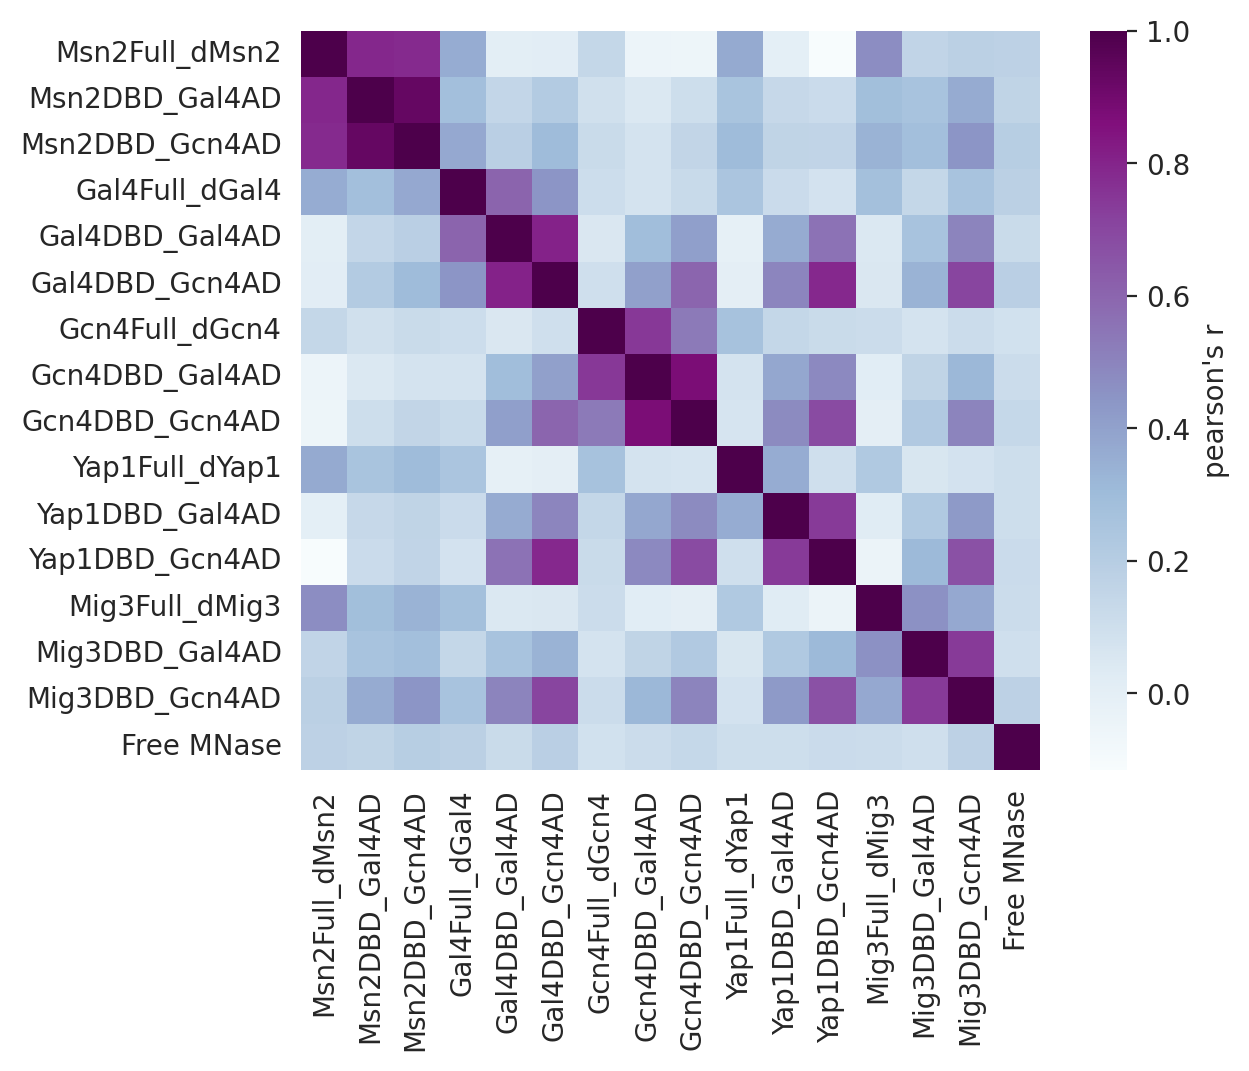

In [5]:
fig, ax = plt.subplots(1)
free_mnase = pd.read_csv('/home/labs/barkailab/vovam/stuff/divya/freemnase_divya.csv', index_col=0).loc[data_waro.index]
free_mnase.columns = ['Free MNase']

sns.heatmap(pd.concat([ordered_df, free_mnase], axis=1).corr(), cmap = 'BuPu', ax=ax, square=True, cbar_kws={'label':'pearson\'s r'})
fig.savefig('figures/Main/fig3/3A.pdf', bbox_inches = 'tight', transparent=True)

# Fig3B

In [6]:
allts = fg.get_targets_df(ordered_df, 3, 'all', '', '')
conc_ts = lambda x: pd.Index(np.concatenate(allts.filter(regex='^'+x, axis=0).loc[:, 'all'].values)).drop_duplicates(keep='first')
f_len = lambda x: allts.filter(regex='^'+x, axis=0).loc[:, 'all'].iloc[0].shape[0]

fig, ax = plt.subplots(5,1, figsize=(5,8))

for i, tfi in enumerate(TFS):
    cts = conc_ts(tfi)
    cbind = gn.get_zscored(ordered_df).filter(regex='^'+tfi).loc[cts]
    d = sns.heatmap(cbind.transpose(), cmap='BuPu', vmin=0, vmax=8, ax=ax[i], xticklabels=False)


    for _, spine in d.spines.items():
        spine.set_visible(True)
    ax[i].axvline(f_len(tfi), c='r')
fig.subplots_adjust(hspace=0)
fig.savefig('figures/Main/fig3/3B.pdf', bbox_inches = 'tight', transparent=True)

# Fig. 3C

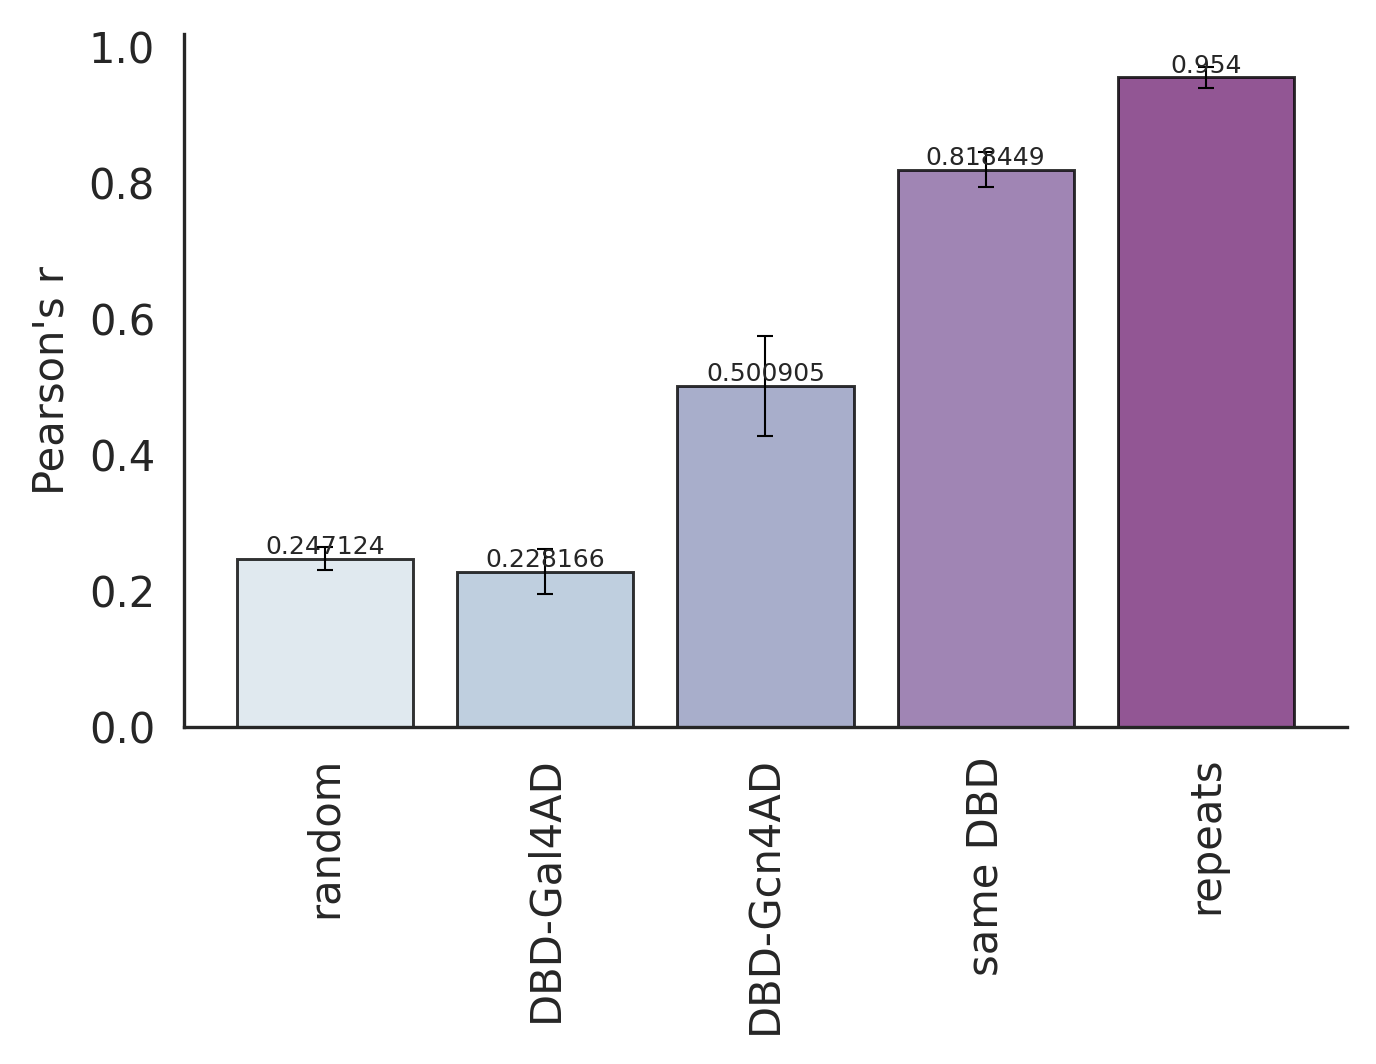

In [8]:
supp_df = pd.concat([tfs_binding_deletions_tef.filter(regex='^{}'.format(i)) for i in TFS], axis=1)
rand = supp_df.corr().replace(1, math.nan).values.reshape(1,-1)[0]
rand = rand[~np.isnan(rand)]
repeats_corrs = [float(name.split('_')[-2]) for name in supp_df.filter(regex='DBD').columns]
ad_corr = lambda x : np.triu(supp_df.filter(regex='DBD').filter(regex=x).corr().values, k=1)[np.triu(supp_df.filter(regex='DBD').filter(regex=x).corr().values, k=1) != 0]
dbdcorr = lambda x: supp_df.filter(regex='DBD').filter(regex='^{}'.format(x)).corr().values[0,1]
dbdcorrdf = pd.DataFrame(zip(TFS, map(dbdcorr, TFS)))
reprd = pd.concat([dbdcorrdf,dbdcorrdf], axis=0)
reprd.loc[:, 'repeats'] = repeats_corrs

from scipy.stats import sem

e = list(sem(reprd.iloc[:, 1:].values))
x = [3,4,1,2,0]
y = list(reprd.iloc[:, 1:].mean().values)
y.append(ad_corr('Gal4AD').mean())
y.append(ad_corr('Gcn4AD').mean())
y.append(np.median(rand))

e.append(sem(ad_corr('Gal4AD')))
e.append(sem(ad_corr('Gcn4AD')))
e.append(sem(rand))


fig, ax = plt.subplots(1, figsize=(5,3),dpi=150)
sns.barplot(x=x,y=y, alpha=.8, ec='k', palette='BuPu', lw=.7)
ax.errorbar(x,y, yerr=e, fmt='None', c='k', capsize=2, capthick=.5, elinewidth=.5)
ax.bar_label(ax.containers[0], fontsize=6);

ax.set_xticks([0,1,2,3,4], labels=['random', 'DBD-Gal4AD', 'DBD-Gcn4AD', 'same DBD', 'repeats'], rotation=90)
ax.set_ylabel('Pearson\'s r')
sns.despine(ax=ax, right=True, top=True)
fig.savefig('figures/Main/fig3/3C.pdf', bbox_inches = 'tight', transparent=True)


# Fig. 3E

In [10]:
gncad_mean = pd.read_csv('data/gcn4ad_isolated.csv', index_col=0)
drop = ['Met31DBD_Gcn4AD_nodeletion_tef_2_reps_0.87_meancorr',
'Reb1DBD_Gal4AD_nodeletion_tef_2_reps_0.95_meancorr',
'Vhr1DBD_Gal4AD_nodeletion_tef_4_reps_0.86_meancorr']

dbdads1 = data_waro.filter(regex='AD').filter(regex='tef').filter(regex='nodeletion').drop(drop, axis=1).sort_index(axis=1)
dbdads2 = data_waro.filter(regex='AD').filter(regex='tef').filter(regex='deletions').sort_index(axis=1)
dbdads = pd.concat([dbdads1, dbdads2], axis=1)
comp = pd.DataFrame(pd.concat([dbdads, gncad_mean], axis=1).corr().iloc[:-1, -1].values.reshape(-1,2))
comp.columns = ['Gal4AD', 'Gcn4AD']

fig, ax = plt.subplots(1)

ax.scatter(y=comp.Gcn4AD, x=comp.Gal4AD, c='#CECAE5', s=140, ec='k', lw=.8)
ax.axline((0,0), slope=1,  c='k', lw=.5, ls='--')
ax.set_ylabel('Corr of DBD-Gcn4AD to Gcn4AD only')
ax.set_xlabel('Corr of DBD-Gal4AD to Gcn4AD only')
ax.set_xlim([0.15, 0.9])
ax.set_ylim([0.1, 0.9])
fig.savefig('figures/Main/fig3/3E.pdf', bbox_inches = 'tight', transparent=True)


# S8B

In [17]:
ads = pd.read_csv('data/newads_Msn2_Gcn4.csv', index_col=0)
predicted_activity = pd.read_csv('data/paddle_ad_activity.csv', index_col=0)
msn2_order = predicted_activity.filter(regex='Msn2', axis=0).index
gcn4_order = predicted_activity.filter(regex='^Gcn4', axis=0).index


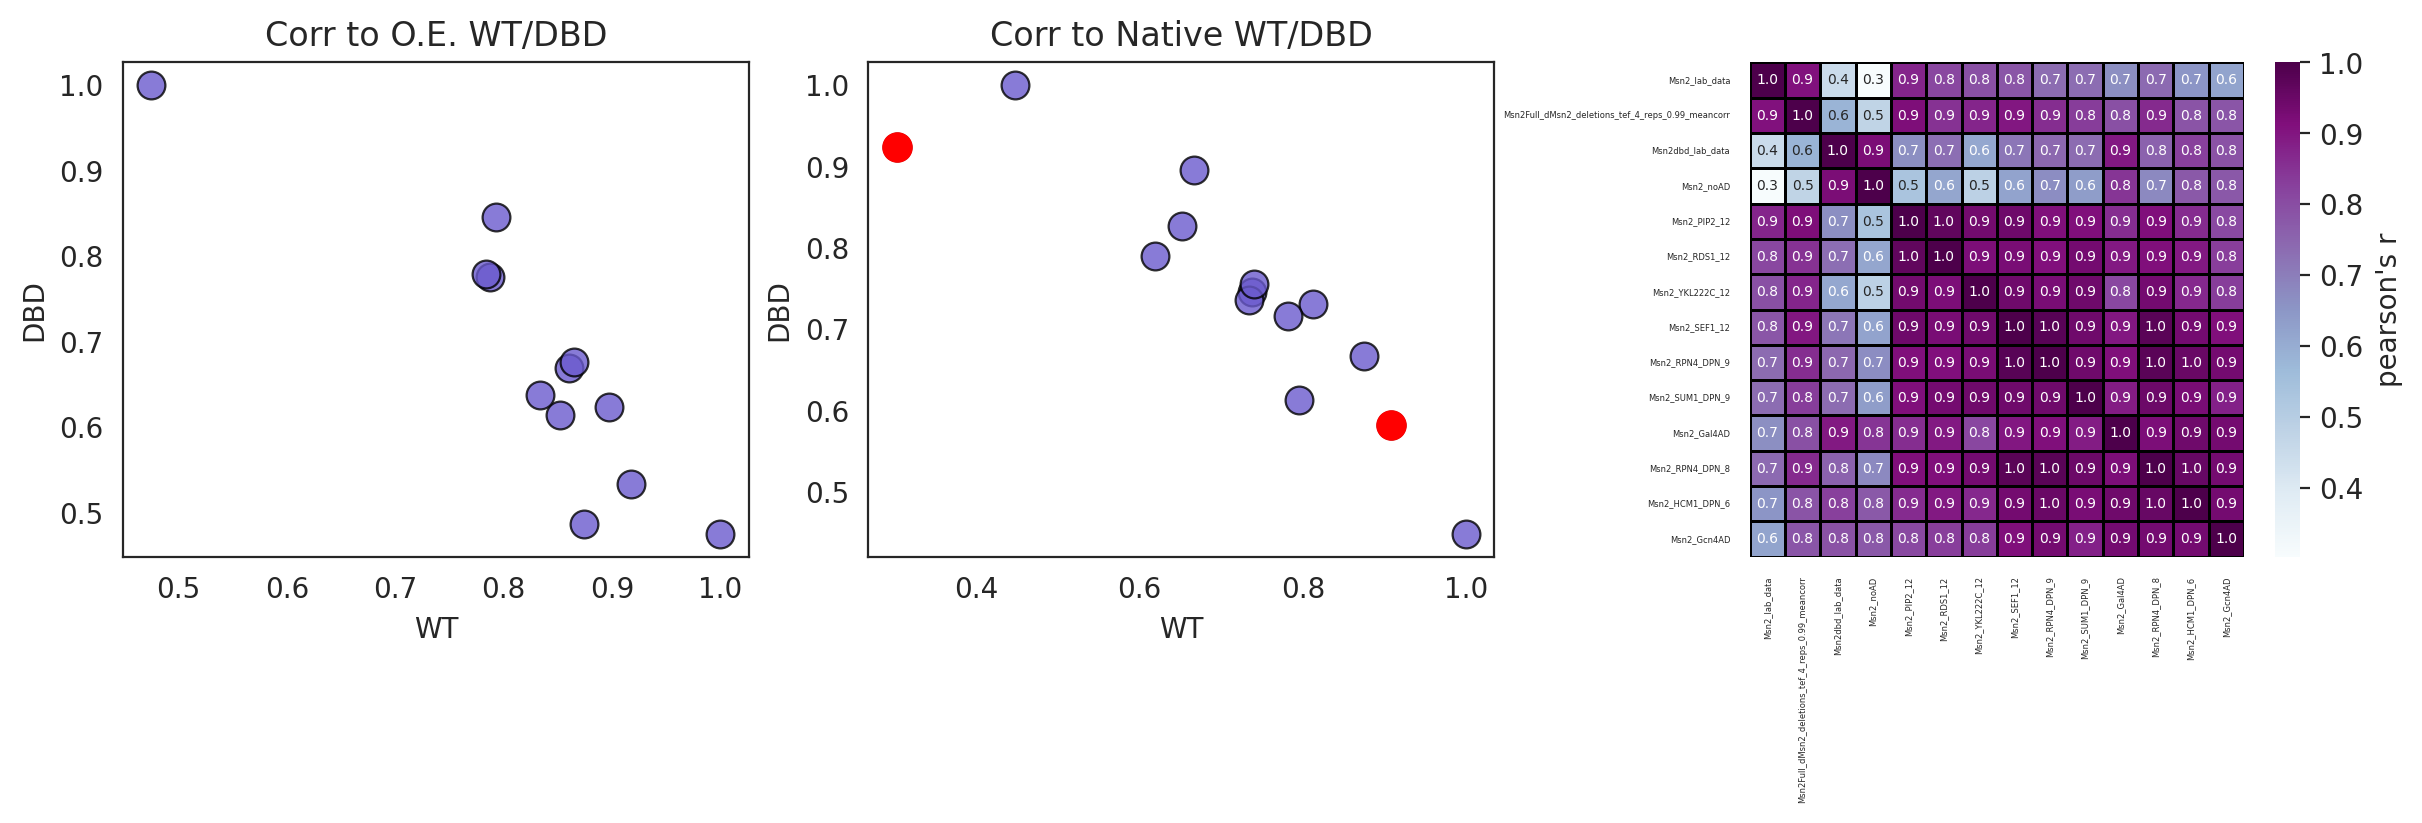

In [18]:
msn2_corr_mat = pd.concat([data_waro.filter(regex='Msn2Full').filter(regex='deletions_tef'), ads.loc[:, msn2_order]], axis=1).corr()
for_scatter = msn2_corr_mat.iloc[:, [0,-1]]
for_scatter.columns = ['WT', 'DBD']

fig, ax = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)
sns.scatterplot(data=for_scatter, x='WT', y='DBD', ax=ax[0], s=100, ec='k', c='slateblue', alpha=.8)


msn2_corr_mat = pd.concat([data_waro.loc[:, ['Msn2Full_dMsn2_deletions_tef_4_reps_0.99_meancorr', 'Msn2_lab_data', 'Msn2dbd_lab_data']], ads.loc[:, msn2_order]], axis=1).corr()
for_scatter = msn2_corr_mat.iloc[:, [1,2]]
for_scatter.columns = ['WT', 'DBD']

sns.scatterplot(data=for_scatter, x='WT', y='DBD', ax=ax[1], s=100, ec='k', c='slateblue', alpha=.8)
ax[1].scatter(for_scatter.iloc[[0,-1], 0], for_scatter.iloc[[0,-1], 1], c='red', s=100,)
ax[0].set_title('Corr to O.E. WT/DBD')
ax[1].set_title('Corr to Native WT/DBD')


df = pd.concat([data_waro.loc[:, ['Msn2_lab_data', 'Msn2Full_dMsn2_deletions_tef_4_reps_0.99_meancorr',  'Msn2dbd_lab_data']],ads.Msn2_noAD, ads.loc[:, msn2_order[:-1]]], axis=1).corr()
sns.heatmap(df, cmap='BuPu', ax=ax[2], annot=True, annot_kws={'size':5}, fmt='.1f', square=True, linecolor='k', linewidths=1, cbar_kws={'label':'pearson\'s r'})

# labels = ['WT', 'WT O.E', 'DBD', 'DBD O.E']
ax[2].set_xticklabels(ax[2].get_xticklabels(), size=3)
ax[2].set_yticklabels(ax[2].get_yticklabels(), size=3)

fig.savefig('figures/Supp/S8B.pdf')

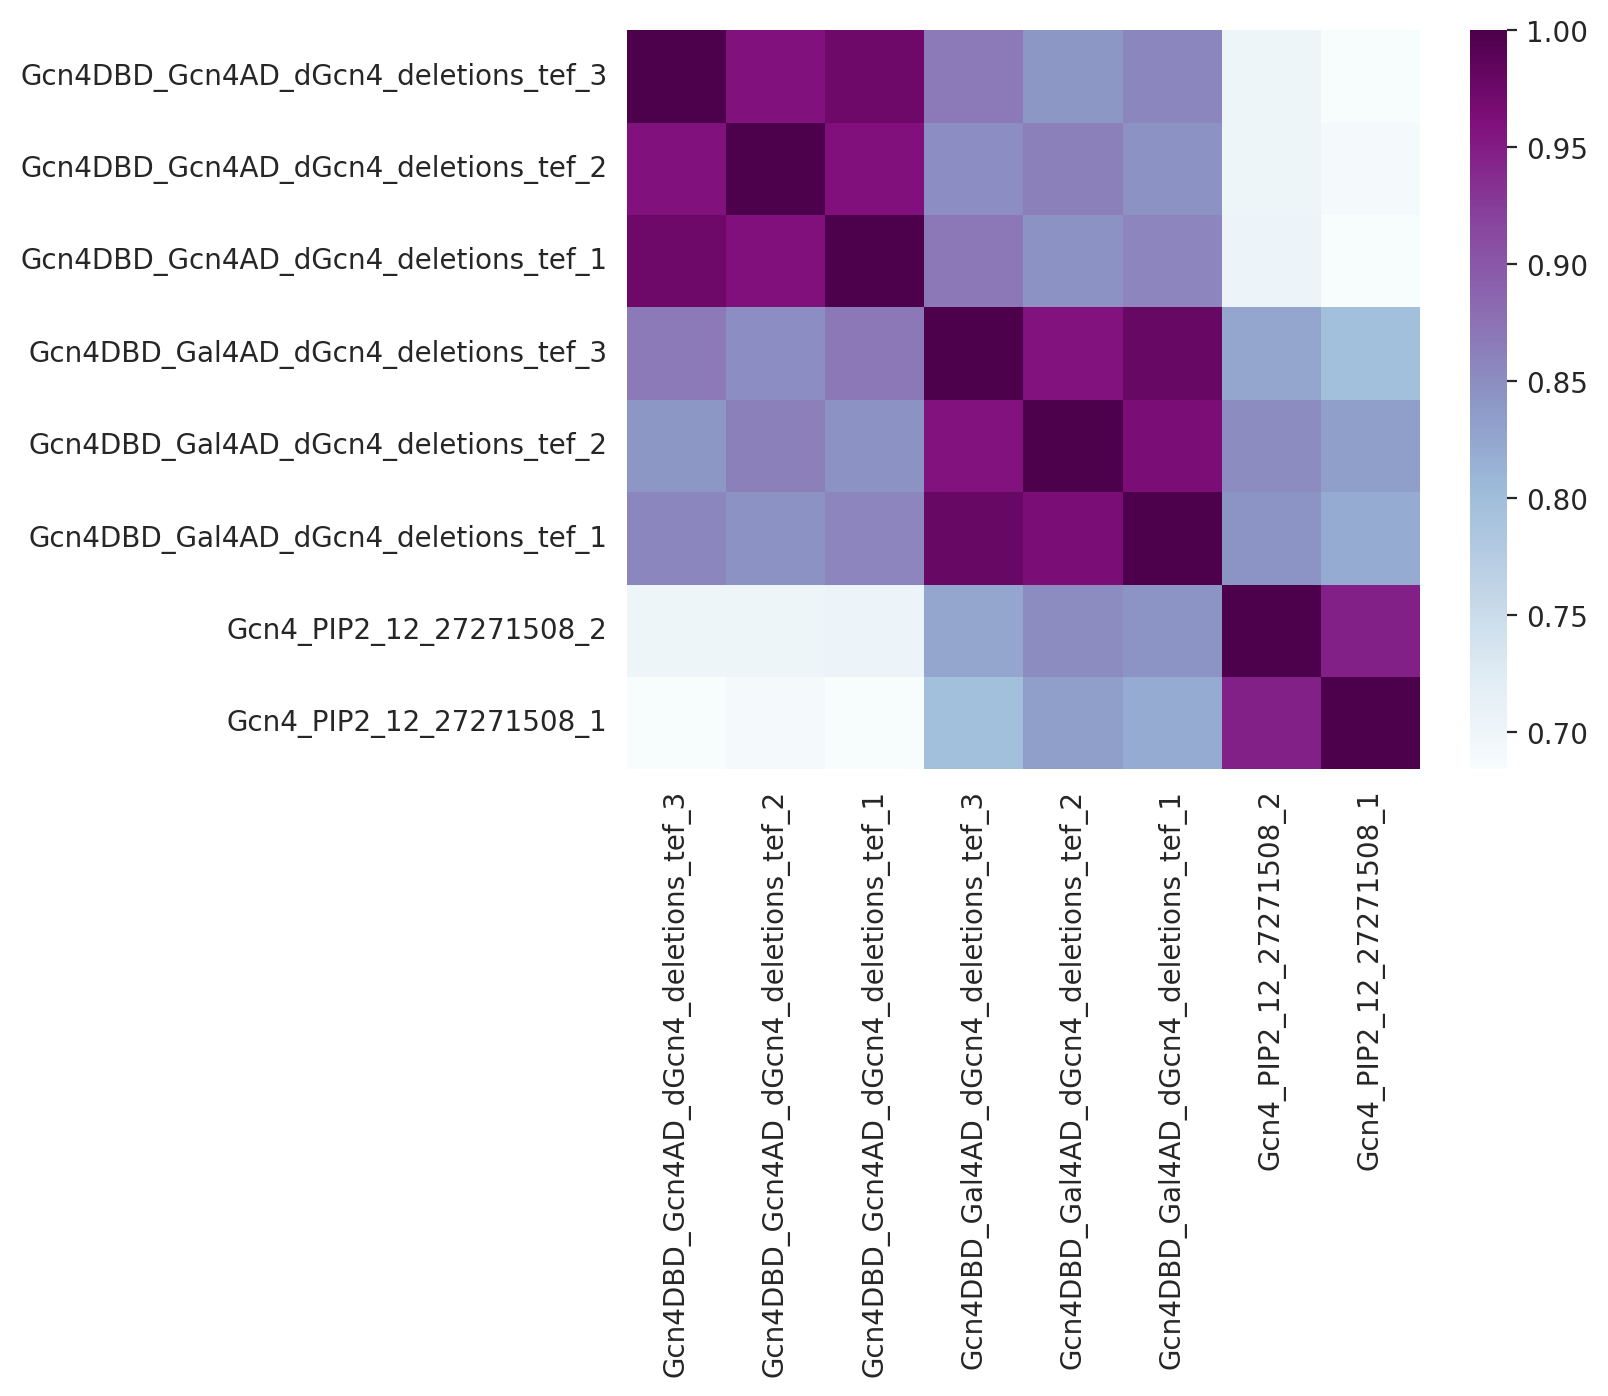

In [21]:
rep_corr = pd.read_csv('data/figure3d_data.csv', index_col=0)
fig, ax = plt.subplots(1)
s = sns.heatmap(rep_corr.corr(), annot=False, cmap='BuPu', ax=ax)
fig.savefig('figures/Main/fig3/3D_cbar.pdf', bbox_inches = 'tight', transparent=True)

# Retrieve the colors used in the heatmap
colorbar = s
color_map = colorbar.collections[0].cmap
color_norm = colorbar.collections[0].norm

# Get the exact colors from the colormap
colors = [color_map(color_norm(value)) for value in rep_corr.corr().values.reshape(1,-1).squeeze()]

# Fig.3D

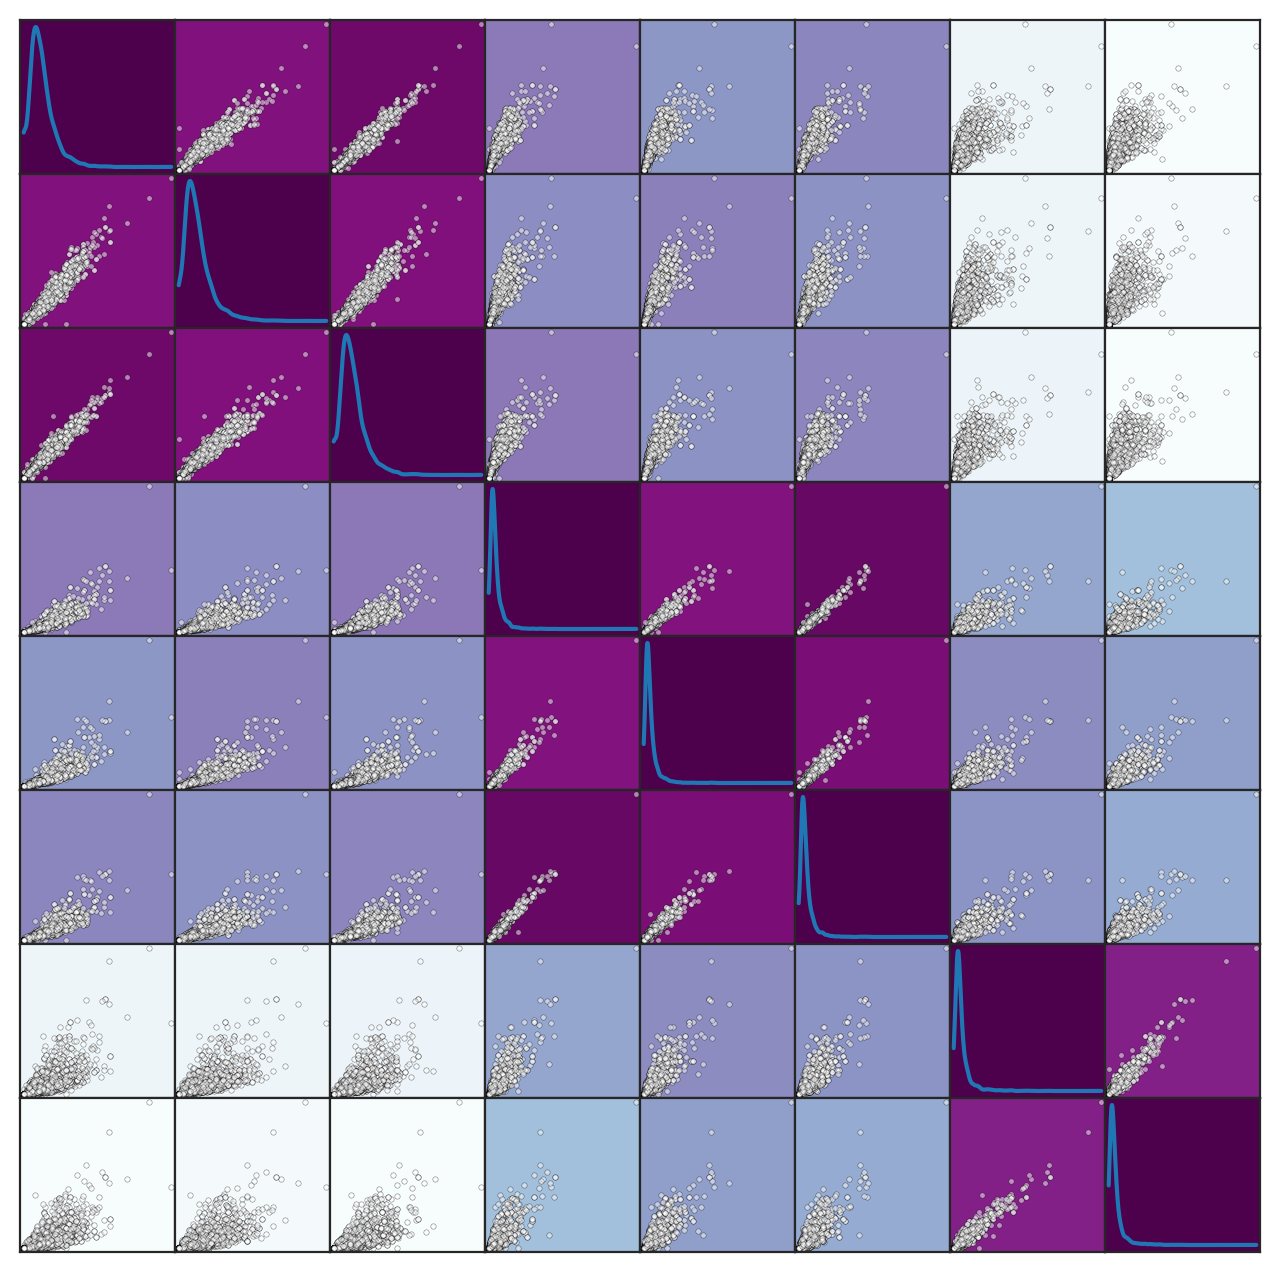

In [22]:
b = pd.plotting.scatter_matrix(rep_corr, s=15, c='white', ec='k', lw=.2, grid=False, diagonal='kde', figsize=(8,8), rasterized=True)

for axi,colori in zip(b.flatten(), colors):
    axi.set_facecolor(colori)
    axi.set_xticklabels('')
    axi.set_yticklabels('')
    axi.set_xlabel('')
    axi.set_ylabel('')
    
plt.savefig('figures/Main/fig3/3D_scatters.pdf', bbox_inches = 'tight', transparent=True)


# S13A

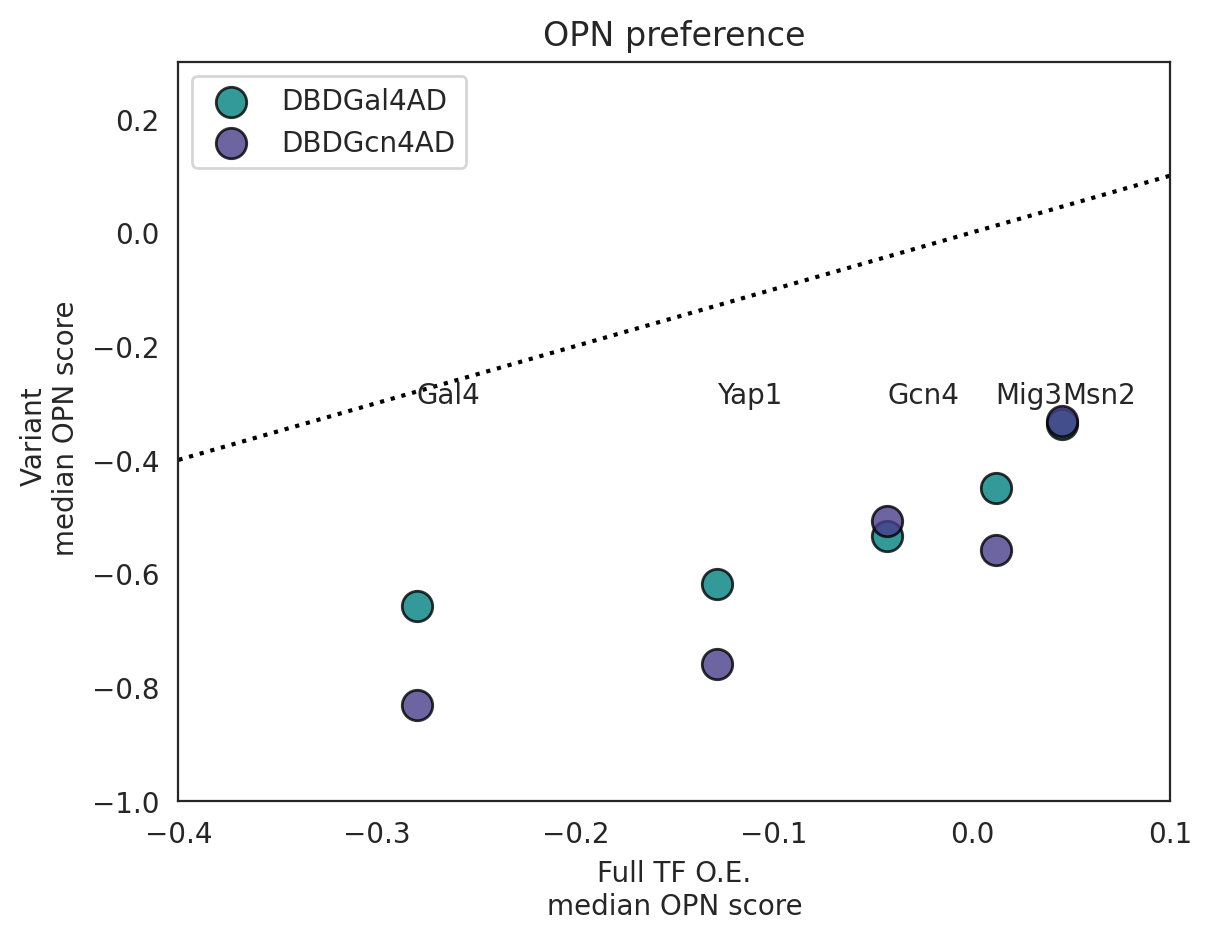

In [23]:
supp_df = data_waro.filter(regex='deletions_tef').filter(regex='^Gal4|^Gcn4|^Msn2|^Yap1|^Mig3')

med_opn = fg.get_targets_df(pd.concat([lab_dat.loc[:, ['Msn2','Gal4', 'Gcn4', 'Yap1', 'Mig3']], supp_df, ], axis=1),3,'all', opn.loc[bins.index[:-1]], '').\
sort_index().applymap(lambda x: opn.opn_score.loc[x].median())
medium_opn = pd.DataFrame(med_opn.values.reshape(-1,4), index=['Gal4', 'Gcn4', 'Mig3', 'Msn2', 'Yap1'], columns=['lab', 'Gal4AD', 'Gcn4AD', 'Full OE']).transpose()
fig, ax = plt.subplots(1,)
x = medium_opn.loc['Full OE',:]
c = ['teal', 'darkslateblue', 'seagreen']
l = ['DBDGal4AD', 'DBDGcn4AD', 'Full OE']
for i in [1,2]:
    ax.scatter(x, medium_opn.iloc[i, :], c=c[i-1], label=l[i-1], s=120, edgecolors='k', alpha=.8, zorder=20)

for ind, val in enumerate(x):
    ax.annotate(x.index[ind], (val, -.3))
ax.legend(loc='upper left')
ax.set_xlim([-.4, .1])
ax.set_ylim([-1, .3])
ax.axline((0,0), slope=1, c='k', linestyle=':', zorder=0)
ax.set_title('OPN preference')
ax.set_xlabel('Full TF O.E.\nmedian OPN score')
ax.set_ylabel('Variant \n median OPN score')
fig.savefig('figures/Supp/S13A.pdf', bbox_inches = 'tight', transparent=True)


## Open Chromatin vs targets singal and hyperchippable regions

In [24]:
def load_data(path, genes):
    return pd.read_pickle(path).loc[genes,:]
nuc_df = pd.read_csv('data/nucleosomes_df_perprom700bp.csv', index_col=0)
allts = fg.get_targets_df(supp_df, 3, 'all', '', '')
dbd_targets = allts.filter(regex='DBD', axis=0)

dbd_targets = allts.filter(regex='DBD', axis=0)
dfl = []
for i in ['Msn2', 'Gal4', 'Gcn4', 'Yap1', 'Mig3']:
    curr_dat = allts.filter(regex='^{}'.format(i), axis=0)
    curr_dat = curr_dat.applymap(lambda x: list(set(x).difference(curr_dat.iloc[0].values[0]))).iloc[1:]
    dfl.append(curr_dat)
unique_ts = pd.concat(dfl, axis=0)

unique_ts = pd.concat([unique_ts, allts.filter(regex='Full', axis=0)] ,axis=0).sort_index(ascending=False)

In [27]:
files = ['data/chec_signals/Gal4Full_dGal4_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr_700bp_signals.gz',
 'data/chec_signals/Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
 'data/chec_signals/Gcn4Full_dGcn4_deletions_tef_3_reps_0.98_meancorr_700bp_signals.gz',
 'data/chec_signals/Gcn4DBD_Gal4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
 'data/chec_signals/Gcn4DBD_Gcn4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
 'data/chec_signals/Msn2Full_dMsn2_deletions_tef_4_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Msn2DBD_Gal4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Msn2DBD_Gcn4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Yap1Full_dYap1_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Yap1DBD_Gal4AD_dYap1_deletions_tef_3_reps_0.82_meancorr_700bp_signals.gz',
 'data/chec_signals/Yap1DBD_Gcn4AD_dYap1_deletions_tef_2_reps_0.97_meancorr_700bp_signals.gz',
 'data/chec_signals/Mig3Full_dMig3_deletions_tef_2_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Mig3DBD_Gal4AD_dMig3_deletions_tef_3_reps_0.94_meancorr_700bp_signals.gz',
 'data/chec_signals/Mig3DBD_Gcn4AD_dMig3_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz']

files = sorted(files, key=lambda x: x.split('/')[-1], reverse=True)
unique_ts.loc[:, 'files'] = files
open_chr_locs = nuc_df.iloc[:, 500:700].sum(axis=1).sort_values().index[:500]

In [29]:
normnames = ['Gal4Full_dGal4_deletions_tef_3_reps_0.99_meancorr',
 'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr',
 'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
 'Gcn4Full_dGcn4_deletions_tef_3_reps_0.98_meancorr',
 'Gcn4DBD_Gal4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr',
 'Gcn4DBD_Gcn4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr',
 'Msn2Full_dMsn2_deletions_tef_4_reps_0.99_meancorr',
 'Msn2DBD_Gal4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr',
 'Msn2DBD_Gcn4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr',
 'Yap1Full_dYap1_deletions_tef_3_reps_0.99_meancorr',
 'Yap1DBD_Gal4AD_dYap1_deletions_tef_3_reps_0.82_meancorr',
 'Yap1DBD_Gcn4AD_dYap1_deletions_tef_2_reps_0.97_meancorr',
 'Mig3Full_dMig3_deletions_tef_2_reps_0.99_meancorr',
 'Mig3DBD_Gal4AD_dMig3_deletions_tef_3_reps_0.94_meancorr',
 'Mig3DBD_Gcn4AD_dMig3_deletions_tef_3_reps_0.97_meancorr',]

titles = ['Gal4Full',
 'Gal4DBD_Gal4AD',
 'Gal4DBD_Gcn4AD',
 'Gcn4Full',
 'Gcn4DBD_Gal4AD',
 'Gcn4DBD_Gcn4AD',
 'Msn2Full',
 'Msn2DBD_Gal4AD',
 'Msn2DBD_Gcn4AD',
 'Yap1Full',
 'Yap1DBD_Gal4AD',
 'Yap1DBD_Gcn4AD',
 'Mig3Full',
 'Mig3DBD_Gal4AD',
 'Mig3DBD_Gcn4AD']

In [30]:
hchip = pd.read_csv('data/hchip.csv', index_col=0)
hchip = hchip.reset_index().iloc[:, :3]

nfiles = glob.glob('data/norm_signals/*_deletions_*')
norm = pd.concat([pd.read_pickle(f) for f in nfiles], axis=1)
norm = norm.loc[:, normnames]

In [31]:
def return_prom_sig_df(df,  coords):
    name = coords[0]
    chrmsm = coords[1]
    start = coords[2]
    stop = coords[3]
    ndf = df.loc[chrmsm]
    if stop-start>0:
        get_sig = lambda x: x[start:stop]
    else:
        print('AAAA!!!!!')
    return (pd.DataFrame(ndf.apply(get_sig).to_dict()).sum() / (stop-start) * 700)
hchip_all = dict(zip(hchip.index, map(return_prom_sig_df, repeat(norm), hchip.reset_index().values)))
hchip_df = pd.DataFrame(hchip_all).transpose()
all_targets = fg.get_targets_df(data_waro, 3, 'df', '', '')
hchip_df = hchip_df.loc[:, sorted(hchip_df.columns, reverse=True)]

# S6A

In [34]:
plot_dat = dict()
for tfi,titi in zip(hchip_df.columns, unique_ts.index):
    plot_dat[tfi] = {'Hyper ChIPable':pd.Series(data_waro.loc[:, tfi].apply(np.log2).values),
 'TF targets':pd.Series(data_waro.loc[unique_ts.loc[titi][0], tfi].apply(np.log2).values)}
hchip_res_df = pd.DataFrame(plot_dat)
hchip_res_df.columns = unique_ts.index

fig = plt.figure(constrained_layout=False, figsize=(7,15))
subf = fig.subfigures(unique_ts.shape[0], 1)
nuc_open_chr_vec = nuc_df.loc[open_chr_locs].mean()

for subi, namei, titlei in zip(subf, unique_ts.index, sorted(titles, reverse=True)):
    op_chr =load_data(unique_ts.loc[namei].iloc[1], open_chr_locs[:len(unique_ts.loc[namei, 'all'])])
    unique_sig =load_data(unique_ts.loc[namei].iloc[1], unique_ts.loc[namei].iloc[0])
    nuc_ts_vec = nuc_df.loc[unique_ts.loc[namei].iloc[0]].mean()

    ax = subi.subplots(1,3, sharey=False, sharex=False)
    twinx1 = ax[0].twinx()
    ax[0].plot(unique_sig.mean(), zorder=20, c='darkslateblue', lw=.5)
    twinx1.fill_between(np.arange(nuc_ts_vec.shape[0]), nuc_ts_vec, alpha=.5, color='gainsboro')

    twinx2 = ax[1].twinx()
    ax[1].plot(op_chr.mean(), zorder=20, c='dimgrey')
    twinx2.fill_between(np.arange(nuc_open_chr_vec.shape[0]), nuc_open_chr_vec, alpha=.5, color='gainsboro')

    ax[0].set_ylabel(titlei, rotation=0, labelpad=55)
    ax[0].axvline(700, c='k', linestyle='--')
    ax[1].axvline(700, c='k', linestyle='--')
    ax[1].set_ylim(ax[0].get_ylim())
    sns.kdeplot(hchip_res_df.loc[:, namei].to_dict(), ax=ax[2],  fill=True, palette=['salmon', 'slateblue'], common_norm=False, legend=False, edgecolor='k', alpha=.8)
    ax[2].set_ylabel('')
    ax[2].set_yticklabels('')
    ax[1].set_yticklabels('')
    ax[2].set_xlim([5,15])
    twinx1.set_yticklabels('')
    twinx2.set_yticklabels('')
fig.savefig('figures/Supp/S6A.pdf')

## Motifs of newly acquired targets

In [36]:
prom_seqs = pd.read_csv('data/gene_sequences.csv',index_col=0)
newseqs = dict()
for key, values in prom_seqs.T.to_dict().items():
    if values['strand'] == 'negative':
        newseqs[key] = values['rseq']
    else:
        newseqs[key] = values['seq']
corr_orient = pd.DataFrame({'seq':newseqs})

In [37]:
motif_files = dict(zip(sorted(all_targets.loc[normnames].filter(regex='DBD', axis=0).index), 
        ['data/motif_pwms/Gal4_in_vitro.pfm',
        'data/motif_pwms/Gal4_in_vitro.pfm',
        'data/motif_pwms/Gcn4_in_vitro.pfm',
        'data/motif_pwms/Gcn4_in_vitro.pfm',
        'data/motif_pwms/Mig3_in_vitro.pfm',
        'data/motif_pwms/Mig3_in_vitro.pfm',
        'data/motif_pwms/Msn2_in_vitro.pfm',
        'data/motif_pwms/Msn2_in_vitro.pfm',
        'data/motif_pwms/Yap1_in_vitro.pfm',
        'data/motif_pwms/Yap1_in_vitro.pfm',
        ]))


motif_files = pd.DataFrame(motif_files, index=['motif']).transpose()

motif_files = motif_files.loc[['Msn2DBD_Gal4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr',
                            'Msn2DBD_Gcn4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr',
                            'Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr',
                            'Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr',
                            'Gcn4DBD_Gal4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr',
                            'Gcn4DBD_Gcn4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr',
                            'Yap1DBD_Gal4AD_dYap1_deletions_tef_3_reps_0.82_meancorr',
                            'Yap1DBD_Gcn4AD_dYap1_deletions_tef_2_reps_0.97_meancorr',
                            'Mig3DBD_Gal4AD_dMig3_deletions_tef_3_reps_0.94_meancorr',
                            'Mig3DBD_Gcn4AD_dMig3_deletions_tef_3_reps_0.97_meancorr',]]
motif_files = motif_files.sort_index(ascending=False)
motif_files.index = unique_ts.filter(regex='DBD', axis=0).index
needed_data = pd.concat([unique_ts.filter(regex='DBD', axis=0), motif_files], axis=1)

In [39]:
thresh = 1000
precision = 10**3
hits = defaultdict(dict)
random = defaultdict(list)
locs = defaultdict(dict)
for dbdi in needed_data.index:
    
    motfile = needed_data.loc[dbdi, 'motif']
    with open(motfile, 'r') as a:
        b, = motifs.parse(a, 'pfm-four-rows')
        b.pseudocounts = pseudocounts
        b.background = background

    distribution = b.pssm.distribution(background=background, precision=precision)
    threshold = distribution.threshold_balanced(thresh)
    
    allmots = []
    for promli in needed_data.loc[dbdi, 'all']:
        seq = corr_orient.loc[promli, 'seq'][-200:]
        if len(seq) > 10:
            allmots.append(len(list(b.pssm.search(seq, threshold=threshold))))
            locs[dbdi][promli] = list(b.pssm.search(seq, threshold=threshold))

    hits[dbdi]= sum(allmots)
    for i in range(1000):
        bootstrap_sample = np.random.choice(prom_seqs.index, size=len(needed_data.loc[dbdi, 'all']), replace=True)
        rand_dist = []
        for promli in bootstrap_sample:
            seq = corr_orient.loc[promli, 'seq'][-200:]
            if len(seq) > 10:
                rand_dist.append(len(list(b.pssm.search(seq, threshold=threshold))))
        random[dbdi].append(sum(rand_dist))

In [40]:
rdf = pd.DataFrame(random)
random_enrich = rdf.div((unique_ts.filter(regex='DBD', axis=0).loc[:, 'all'].apply(lambda x: len(x))).values, axis=1)
true_enrich = (pd.DataFrame(hits, index=['hits']).T).div(unique_ts.filter(regex='DBD', axis=0).loc[:, 'all'].apply(lambda x: len(x)).values, axis=0)

for i in np.arange(random_enrich.shape[1]):
    z_test = scipy.stats.norm.sf(abs((true_enrich.iloc[i].values - random_enrich.iloc[:,i].values.mean()) / random_enrich.iloc[:,i].values.std()))
    print(z_test)
    print(z_test < 0.005)

[4.51380115e-05]
[ True]
[9.59962009e-06]
[ True]
[1.2805439e-07]
[ True]
[1.05836507e-18]
[ True]
[0.00307939]
[ True]
[0.00060107]
[ True]
[0.0001419]
[ True]
[2.87272644e-08]
[ True]
[0.30219395]
[False]
[0.00853692]
[False]


# S7B

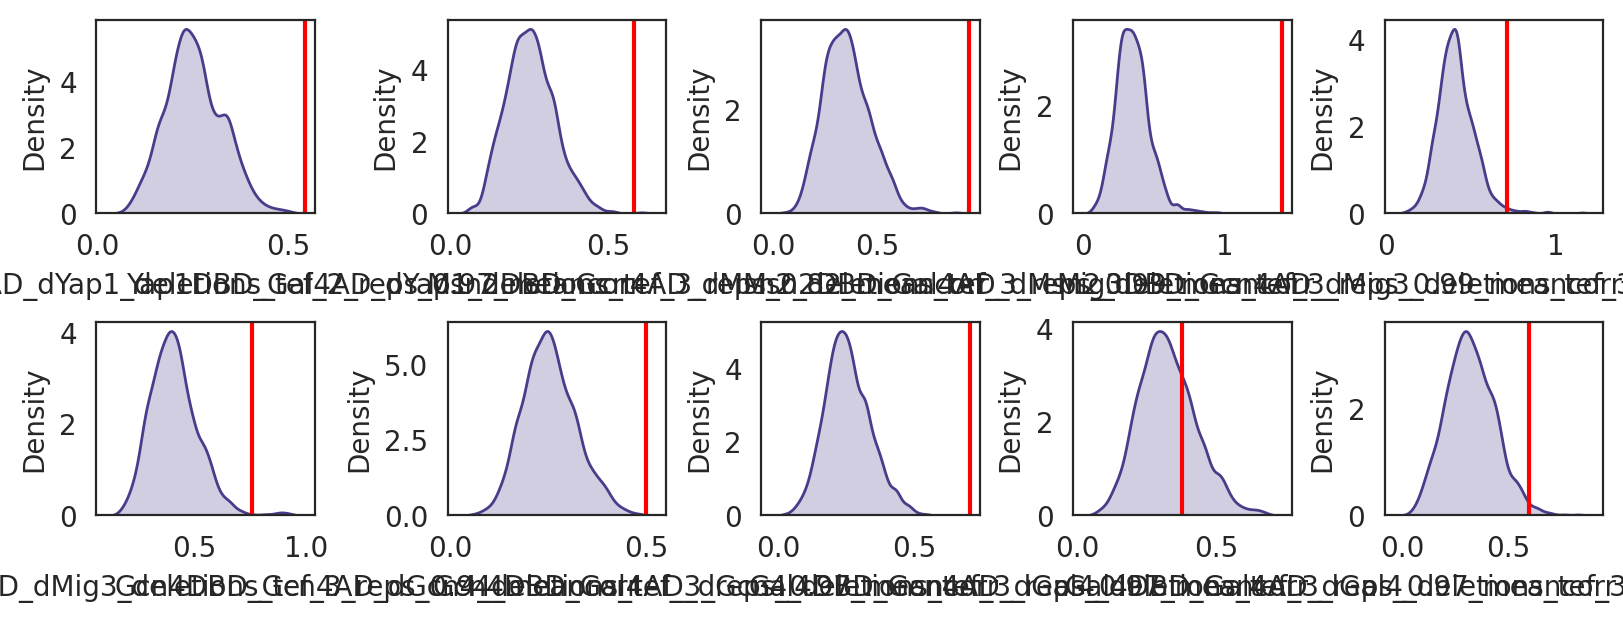

In [41]:
fig, ax = plt.subplots(2,5, constrained_layout=True, figsize=(8,3), sharey=False,)
ax = ax.flatten()

for i, axi in enumerate(ax):
    sns.kdeplot(random_enrich.iloc[:, i], ax=axi,fill=True, color='darkslateblue', bw_adjust=.8)
    axi.axvline(true_enrich.iloc[i].values, c='r')
fig.savefig('figures/Supp/S7B.pdf')

In [42]:
files = [ 'data/chec_signals/Msn2DBD_Gal4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz',
 'data/chec_signals/Msn2DBD_Gcn4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr_700bp_signals.gz',
  'data/chec_signals/Gal4DBD_Gal4AD_dGal4_deletions_tef_3_reps_0.95_meancorr_700bp_signals.gz',
  'data/chec_signals/Gal4DBD_Gcn4AD_dGal4_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
   'data/chec_signals/Gcn4DBD_Gal4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
 'data/chec_signals/Gcn4DBD_Gcn4AD_dGcn4_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
'data/chec_signals/Yap1DBD_Gal4AD_dYap1_deletions_tef_3_reps_0.82_meancorr_700bp_signals.gz',
 'data/chec_signals/Yap1DBD_Gcn4AD_dYap1_deletions_tef_2_reps_0.97_meancorr_700bp_signals.gz',
 'data/chec_signals/Mig3DBD_Gal4AD_dMig3_deletions_tef_3_reps_0.94_meancorr_700bp_signals.gz',
 'data/chec_signals/Mig3DBD_Gcn4AD_dMig3_deletions_tef_3_reps_0.97_meancorr_700bp_signals.gz',
]

In [43]:
locs_df = pd.DataFrame(locs).applymap(lambda x: np.nan if x == [] else x)
hits_df = pd.DataFrame(hits, index=['hits'])

# S7A

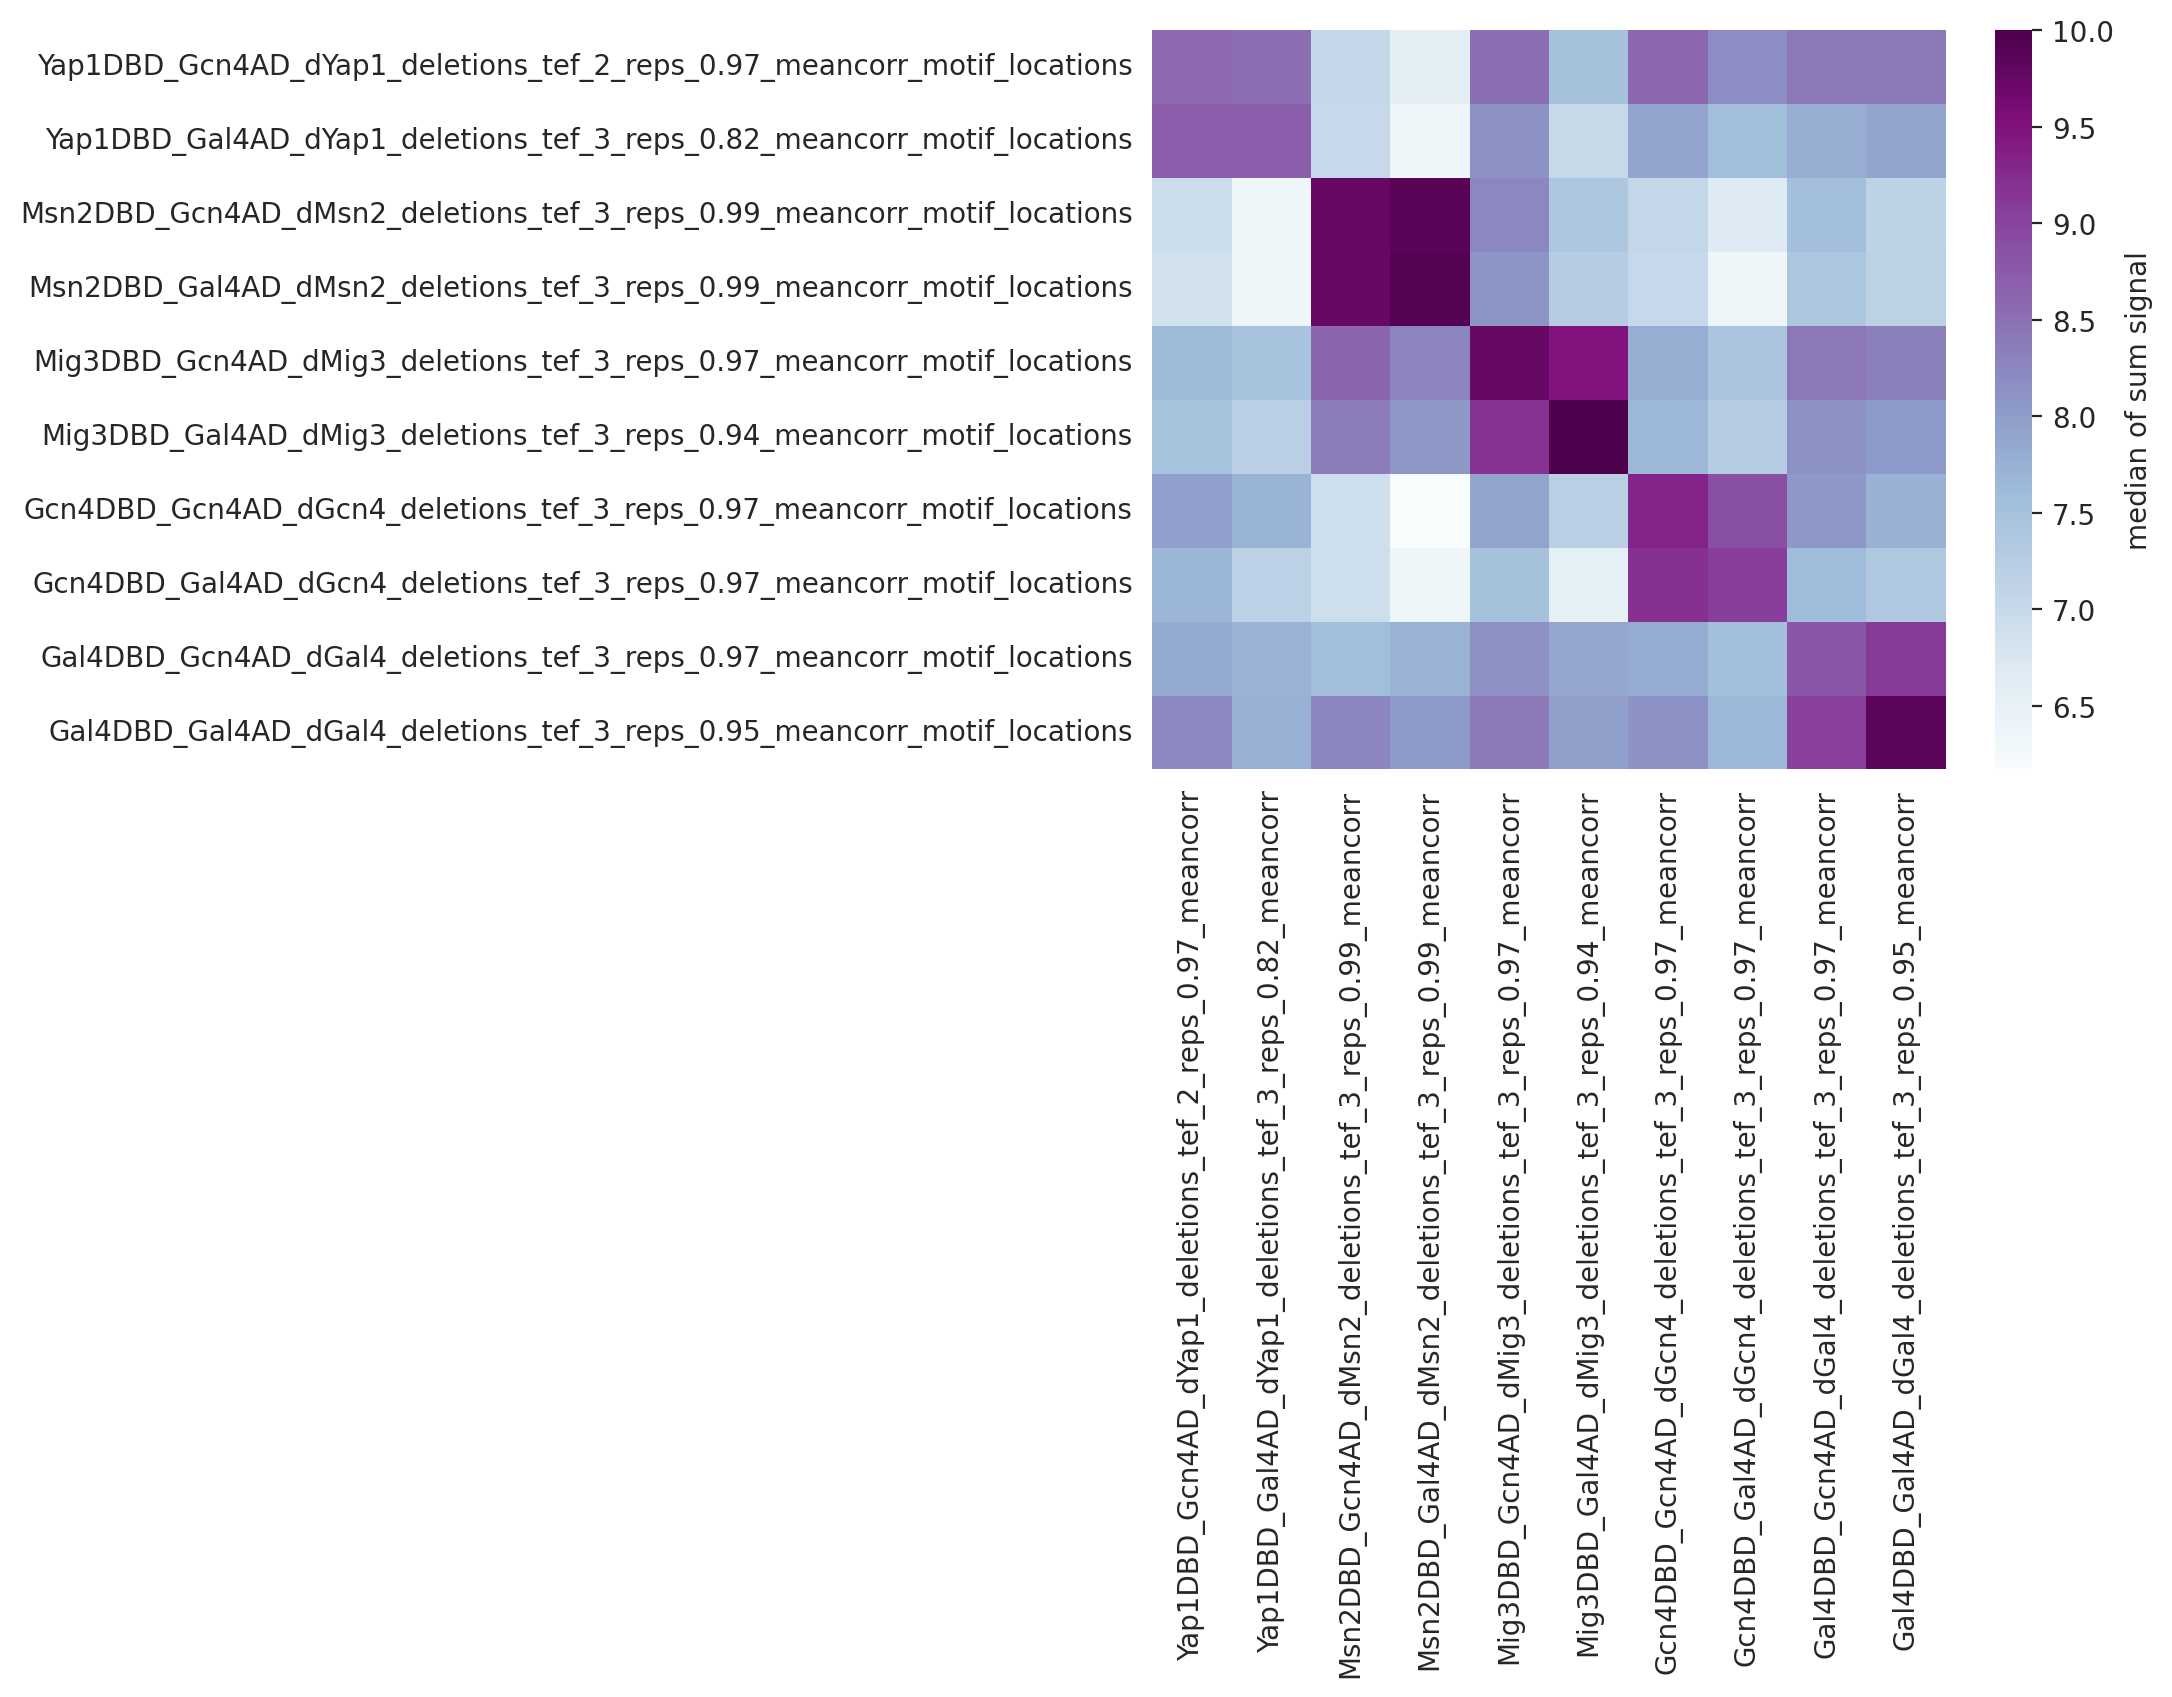

In [44]:
sig_mat = defaultdict(dict)
for inhits in hits_df.columns:
    chits = locs_df.loc[:, inhits].dropna().to_dict().items()
    
    for file in files:
        cdata = pd.read_pickle(file)
        sigs=[]
        for key, values in chits:
            for mloc in values:
                sigs.append(cdata.loc[key, 700-200:700].iloc[mloc[0]-50: mloc[0]+55].values)
        sig_mat[file][inhits] = sigs
sig_df = pd.DataFrame(sig_mat)
sum_sig_df = sig_df.applymap(lambda x: pd.DataFrame(x).sum(axis=1).median())
sum_sig_df = sig_df.applymap(lambda x: pd.DataFrame(x).sum(axis=1).median())
sum_sig_df = sum_sig_df.sort_index(axis=1, ascending=False)
sum_sig_df.columns = needed_data.filter(regex='DBD', axis=0).index
sum_sig_df.index = [name+'_motif_locations' for name in sum_sig_df.index]

fig,ax = plt.subplots(1)
sns.heatmap(np.log2(sum_sig_df), ax=ax, cbar_kws={'label':'median of sum signal'}, cmap='BuPu', vmax=10)
fig.savefig('figures/Supp/S7A.pdf')

# S8A

In [45]:
dbd_isolated = pd.read_pickle('data/dbd_data.gz').loc[data_waro.index]

clab_dat = data_waro.loc[:, ['Crz1_lab_data',  'Mig3_lab_data' , 'Sko1_lab_data', 'Yap1_lab_data', 'Gln3_lab_data', 'Msn2_lab_data']]

cdbdad_dat = data_waro.loc[:, ['Yap1DBD_Gal4AD_dYap1_deletions_tef_3_reps_0.82_meancorr',
                                'Yap1DBD_Gcn4AD_dYap1_deletions_tef_2_reps_0.97_meancorr',
                                'Mig3DBD_Gal4AD_dMig3_deletions_tef_3_reps_0.94_meancorr',
                                'Mig3DBD_Gcn4AD_dMig3_deletions_tef_3_reps_0.97_meancorr',
                                'Crz1DBD_Gcn4AD_nodeletion_tef_2_reps_0.97_meancorr',
                                'Gln3DBD_Gal4AD_dGln3_deletions_tef_3_reps_0.93_meancorr',
                                'Gln3DBD_Gcn4AD_dGln3_deletions_tef_2_reps_0.94_meancorr',
                                'Msn2DBD_Gal4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr',
                                'Msn2DBD_Gcn4AD_dMsn2_deletions_tef_3_reps_0.99_meancorr',
                                'Sko1DBD_Gal4AD_nodeletion_tef_2_reps_0.9_meancorr',
                                'Sko1DBD_Gcn4AD_nodeletion_tef_2_reps_0.95_meancorr',
                                ]]
fulloe = data_waro.loc[:, [ 'Yap1Full_dYap1_deletions_tef_3_reps_0.99_meancorr',
                            'Mig3Full_dMig3_deletions_tef_2_reps_0.99_meancorr',
                            'Msn2Full_dMsn2_deletions_tef_4_reps_0.99_meancorr',
                            'Sko1Full_nodeletion_tef_2_reps_0.86_meancorr',
                            'Gln3Full_dGln3_deletions_tef_2_reps_0.97_meancorr']]

merged = pd.concat([clab_dat, fulloe, cdbdad_dat, dbd_isolated, data_waro.loc[:, 'Msn2dbd_lab_data']], axis=1)
ctfs = ['Crz1', 'Mig', 'Gln', 'Yap1', 'Sko', 'Msn2']

fig, ax = plt.subplots(1, len(ctfs), figsize=(28,3), constrained_layout=False)

for tfi, axi in zip(ctfs, ax):
    cd = merged.filter(regex='^'+tfi)
    sns.heatmap(cd.corr(), ax=axi, cmap='BuPu', square=True, annot=True, vmin=0, vmax=1)
    axi.set_xticklabels(["_".join(name.split('_')[:2]) for name in cd.columns])
    axi.set_yticklabels(["_".join(name.split('_')[:2]) for name in cd.columns])

fig.subplots_adjust(wspace=1)

fig.savefig('figures/Supp/S8A.pdf')